# Retrain Floor Evaluation

**Purpose:** Compute AUC_floor on gold-standard retrain (D\F) to establish realistic privacy target.

**Task:** Evaluate strongest attacker on full retrain model:
- F vs Unseen (matched negatives)
- F vs Retain (matched)
- Report AUC with 95% CI
- Report TPR @ 1% and 0.1% FPR
- Set target band: AUC_floor ± 0.03

In [1]:
import sys
sys.path.append('src')

import torch
import scanpy as sc
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from vae import VAE
from attacker import MLPAttacker, extract_vae_features, build_attack_features

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Load Data and Splits

In [2]:
# Load data
adata = sc.read_h5ad('data/adata_processed.h5ad')
with open('outputs/p1/split_structured.json', 'r') as f:
    splits = json.load(f)

forget_idx = np.array(splits['forget_indices'])
retain_idx = np.array(splits['retain_indices'])
unseen_idx = np.array(splits['unseen_indices'])

print("Split sizes:")
print(f"  Forget:  {len(forget_idx):5d} cells (rare cluster)")
print(f"  Retain:  {len(retain_idx):5d} cells (training set minus forget)")
print(f"  Unseen:  {len(unseen_idx):5d} cells (matched negatives from same cluster)")
print(f"  Total:   {adata.n_obs:5d} cells")

Split sizes:
  Forget:     30 cells (rare cluster)
  Retain:  28094 cells (training set minus forget)
  Unseen:   4964 cells (matched negatives from same cluster)
  Total:   33088 cells


## 2. Load Gold-Standard Retrain Model

In [3]:
# Load retrained VAE (full retrain on D\F)
retrain_ckpt = torch.load('outputs/p1/retrain_structured/best_model.pt', map_location=device)
vae_config = retrain_ckpt['config']

# Retrain checkpoint doesn't have input_dim, need to infer from data
input_dim = adata.n_vars  # 2000 genes

vae = VAE(
    input_dim=input_dim,
    hidden_dims=vae_config['hidden_dims'],
    latent_dim=vae_config['latent_dim'],
    likelihood=vae_config['likelihood'],
    dropout=vae_config.get('dropout', 0.0),
    use_layer_norm=vae_config.get('use_layer_norm', False)
).to(device)

vae.load_state_dict(retrain_ckpt['model_state_dict'])
vae.eval()

print("Retrained VAE loaded:")
print(f"  Architecture: {input_dim} -> {vae_config['hidden_dims']} -> z={vae_config['latent_dim']}")
print(f"  Likelihood: {vae_config['likelihood']}")
print(f"  Training set: {len(retain_idx)} cells (D\\F)")

Retrained VAE loaded:
  Architecture: 2000 -> [512, 128] -> z=16
  Likelihood: nb
  Training set: 28094 cells (D\F)


## 3. Extract VAE Features for Attacker

In [4]:
def get_features(indices, name):
    """Extract attacker features for a set of indices."""
    X = torch.FloatTensor(
        adata.X[indices].toarray() if hasattr(adata.X[indices], 'toarray')
        else adata.X[indices]
    )
    lib = torch.FloatTensor(X.sum(dim=1, keepdim=True))

    with torch.no_grad():
        vae_feats = extract_vae_features(vae, X.to(device), lib.to(device), device)
        attack_feats = build_attack_features(vae_feats)

    print(f"  {name:10s}: {attack_feats.shape}")
    return attack_feats.cpu().numpy()

print("Extracting features...")
forget_feats = get_features(forget_idx, 'Forget')
unseen_feats = get_features(unseen_idx, 'Unseen')
retain_feats = get_features(retain_idx, 'Retain')

feature_dim = forget_feats.shape[1]
print(f"\nTotal feature dimension: {feature_dim}")

Extracting features...
  Forget    : torch.Size([30, 37])


  Unseen    : torch.Size([4964, 37])


  Retain    : torch.Size([28094, 37])

Total feature dimension: 37


## 4. Train Strongest Attacker (v1)

Train a post-hoc MIA attacker on the retrained model to measure residual privacy leakage.

In [5]:
# Initialize attacker
attacker = MLPAttacker(
    feature_dim,
    [256, 256],
    dropout=0.3,
    use_spectral_norm=True
).to(device)

optimizer = torch.optim.Adam(attacker.parameters(), lr=0.001, weight_decay=1e-4)

print("Training attacker (100 epochs)...")
print(f"  Architecture: {feature_dim} -> [256, 256] -> 1")
print(f"  Dropout: 0.3, Spectral norm: True")
print("")

# Training loop
attacker.train()
train_losses = []

for epoch in range(100):
    # Sample batches
    f_idx = np.random.choice(len(forget_feats), min(64, len(forget_feats)), replace=False)
    r_idx = np.random.choice(len(retain_feats), min(64, len(retain_feats)), replace=False)

    f_batch = torch.FloatTensor(forget_feats[f_idx]).to(device)
    r_batch = torch.FloatTensor(retain_feats[r_idx]).to(device)

    optimizer.zero_grad()
    logits_f = attacker(f_batch)
    logits_r = attacker(r_batch)

    loss_f = torch.nn.functional.binary_cross_entropy_with_logits(
        logits_f, torch.ones_like(logits_f)
    )
    loss_r = torch.nn.functional.binary_cross_entropy_with_logits(
        logits_r, torch.zeros_like(logits_r)
    )
    loss = (loss_f + loss_r) / 2

    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d}/100 | Loss: {loss.item():.4f} | F: {loss_f.item():.4f} | R: {loss_r.item():.4f}")

print("\nAttacker training complete.")

Training attacker (100 epochs)...
  Architecture: 37 -> [256, 256] -> 1
  Dropout: 0.3, Spectral norm: True

Epoch  20/100 | Loss: 0.7573 | F: 0.8837 | R: 0.6310


Epoch  40/100 | Loss: 0.6978 | F: 0.9000 | R: 0.4956
Epoch  60/100 | Loss: 0.7054 | F: 0.7069 | R: 0.7039
Epoch  80/100 | Loss: 0.7040 | F: 0.8229 | R: 0.5851


Epoch 100/100 | Loss: 0.6746 | F: 0.7409 | R: 0.6083

Attacker training complete.


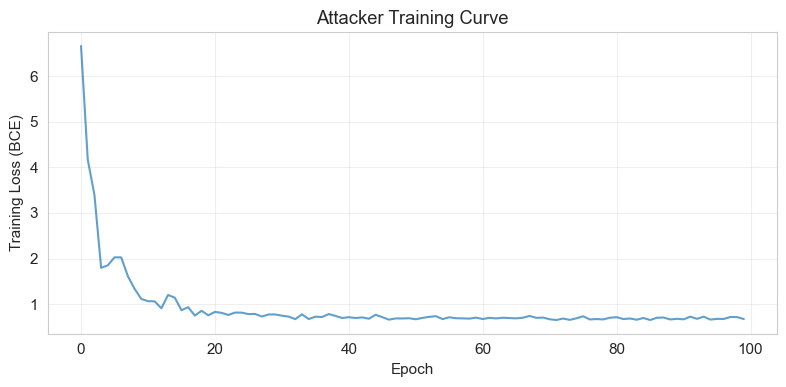

In [6]:
# Plot training curve
plt.figure(figsize=(8, 4))
plt.plot(train_losses, alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Training Loss (BCE)')
plt.title('Attacker Training Curve')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Evaluate Attacker: Compute AUC and Low-FPR Metrics

In [7]:
# Get predictions
attacker.eval()
with torch.no_grad():
    forget_preds = torch.sigmoid(attacker(torch.FloatTensor(forget_feats).to(device))).cpu().numpy()
    unseen_preds = torch.sigmoid(attacker(torch.FloatTensor(unseen_feats).to(device))).cpu().numpy()
    retain_preds = torch.sigmoid(attacker(torch.FloatTensor(retain_feats).to(device))).cpu().numpy()

print("Prediction statistics:")
print(f"  Forget: {forget_preds.mean():.4f} ± {forget_preds.std():.4f}")
print(f"  Unseen: {unseen_preds.mean():.4f} ± {unseen_preds.std():.4f}")
print(f"  Retain: {retain_preds.mean():.4f} ± {retain_preds.std():.4f}")

Prediction statistics:
  Forget: 0.5104 ± 0.0245
  Unseen: 0.4731 ± 0.0247
  Retain: 0.4734 ± 0.0248


In [8]:
# F vs Unseen (matched negatives)
y_f_vs_u = np.concatenate([np.ones(len(forget_preds)), np.zeros(len(unseen_preds))])
scores_f_vs_u = np.concatenate([forget_preds.flatten(), unseen_preds.flatten()])
auc_f_vs_u = roc_auc_score(y_f_vs_u, scores_f_vs_u)

# F vs Retain
y_f_vs_r = np.concatenate([np.ones(len(forget_preds)), np.zeros(len(retain_preds))])
scores_f_vs_r = np.concatenate([forget_preds.flatten(), retain_preds.flatten()])
auc_f_vs_r = roc_auc_score(y_f_vs_r, scores_f_vs_r)

print(f"\nAUC (without CI):")
print(f"  F vs Unseen: {auc_f_vs_u:.4f}")
print(f"  F vs Retain: {auc_f_vs_r:.4f}")


AUC (without CI):
  F vs Unseen: 0.8650
  F vs Retain: 0.8637


In [9]:
# Bootstrap confidence intervals
def bootstrap_auc_ci(y_true, y_score, n_bootstrap=1000, confidence=0.95):
    """Compute bootstrap confidence interval for AUC."""
    n = len(y_true)
    aucs = []
    np.random.seed(42)
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, n, replace=True)
        try:
            auc = roc_auc_score(y_true[idx], y_score[idx])
            aucs.append(auc)
        except:
            pass
    aucs = np.array(aucs)
    alpha = 1 - confidence
    lower = np.percentile(aucs, 100 * alpha / 2)
    upper = np.percentile(aucs, 100 * (1 - alpha / 2))
    return lower, upper

print("Computing 95% confidence intervals (1000 bootstrap samples)...")
ci_f_vs_u = bootstrap_auc_ci(y_f_vs_u, scores_f_vs_u)
ci_f_vs_r = bootstrap_auc_ci(y_f_vs_r, scores_f_vs_r)

print(f"  F vs Unseen: [{ci_f_vs_u[0]:.4f}, {ci_f_vs_u[1]:.4f}]")
print(f"  F vs Retain: [{ci_f_vs_r[0]:.4f}, {ci_f_vs_r[1]:.4f}]")

Computing 95% confidence intervals (1000 bootstrap samples)...


  F vs Unseen: [0.7873, 0.9252]
  F vs Retain: [0.7836, 0.9245]


In [10]:
# TPR at low FPR
def compute_tpr_at_fpr(y_true, y_score, fpr_thresholds=[0.01, 0.001]):
    """Compute TPR at specific FPR thresholds."""
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    results = {}
    for target_fpr in fpr_thresholds:
        # Find threshold where FPR is closest to target
        idx = np.argmin(np.abs(fpr - target_fpr))
        results[f'tpr@{target_fpr:.1%}fpr'] = tpr[idx]
        results[f'fpr_actual@{target_fpr:.1%}fpr'] = fpr[idx]
    return results, fpr, tpr

tpr_f_vs_u, fpr_f_vs_u, tpr_curve_f_vs_u = compute_tpr_at_fpr(y_f_vs_u, scores_f_vs_u)
tpr_f_vs_r, fpr_f_vs_r, tpr_curve_f_vs_r = compute_tpr_at_fpr(y_f_vs_r, scores_f_vs_r)

print("\nTPR at Low FPR (F vs Unseen):")
print(f"  TPR @ 1.0% FPR: {tpr_f_vs_u['tpr@1.0%fpr']:.4f} (actual FPR: {tpr_f_vs_u['fpr_actual@1.0%fpr']:.4f})")
print(f"  TPR @ 0.1% FPR: {tpr_f_vs_u['tpr@0.1%fpr']:.4f} (actual FPR: {tpr_f_vs_u['fpr_actual@0.1%fpr']:.4f})")

print("\nTPR at Low FPR (F vs Retain):")
print(f"  TPR @ 1.0% FPR: {tpr_f_vs_r['tpr@1.0%fpr']:.4f} (actual FPR: {tpr_f_vs_r['fpr_actual@1.0%fpr']:.4f})")
print(f"  TPR @ 0.1% FPR: {tpr_f_vs_r['tpr@0.1%fpr']:.4f} (actual FPR: {tpr_f_vs_r['fpr_actual@0.1%fpr']:.4f})")


TPR at Low FPR (F vs Unseen):
  TPR @ 1.0% FPR: 0.0667 (actual FPR: 0.0117)
  TPR @ 0.1% FPR: 0.0000 (actual FPR: 0.0016)

TPR at Low FPR (F vs Retain):
  TPR @ 1.0% FPR: 0.0667 (actual FPR: 0.0128)
  TPR @ 0.1% FPR: 0.0000 (actual FPR: 0.0000)


## 6. Visualize ROC Curves

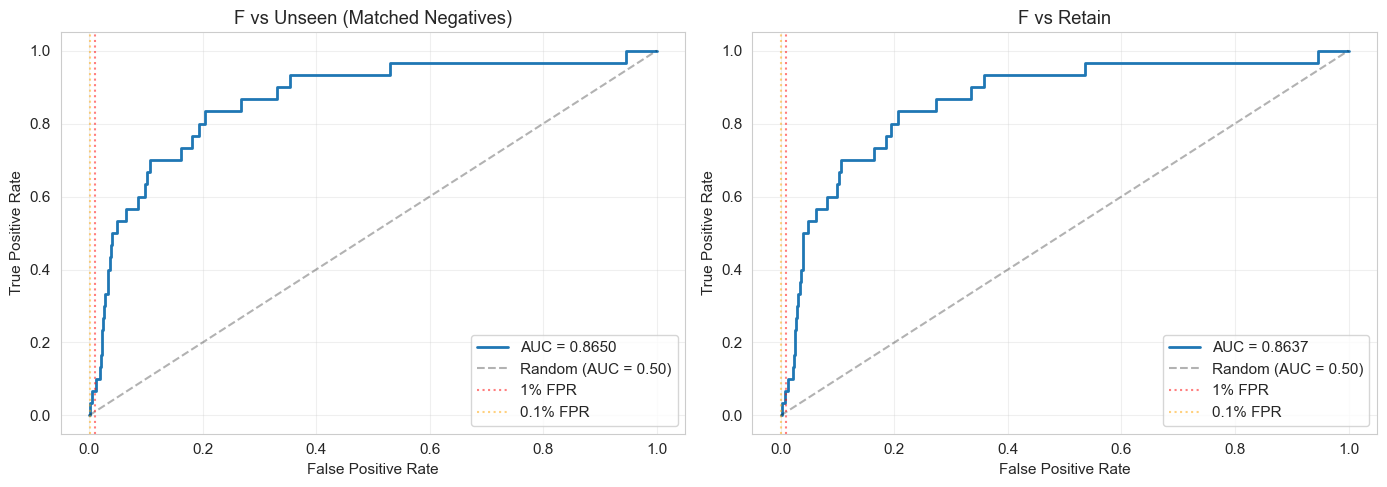

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F vs Unseen
axes[0].plot(fpr_f_vs_u, tpr_curve_f_vs_u, linewidth=2, label=f'AUC = {auc_f_vs_u:.4f}')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random (AUC = 0.50)')
axes[0].axvline(0.01, color='red', linestyle=':', alpha=0.5, label='1% FPR')
axes[0].axvline(0.001, color='orange', linestyle=':', alpha=0.5, label='0.1% FPR')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('F vs Unseen (Matched Negatives)')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# F vs Retain
axes[1].plot(fpr_f_vs_r, tpr_curve_f_vs_r, linewidth=2, label=f'AUC = {auc_f_vs_r:.4f}')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random (AUC = 0.50)')
axes[1].axvline(0.01, color='red', linestyle=':', alpha=0.5, label='1% FPR')
axes[1].axvline(0.001, color='orange', linestyle=':', alpha=0.5, label='0.1% FPR')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('F vs Retain')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/p2/retrain_floor_roc.png', dpi=150, bbox_inches='tight')
plt.show()

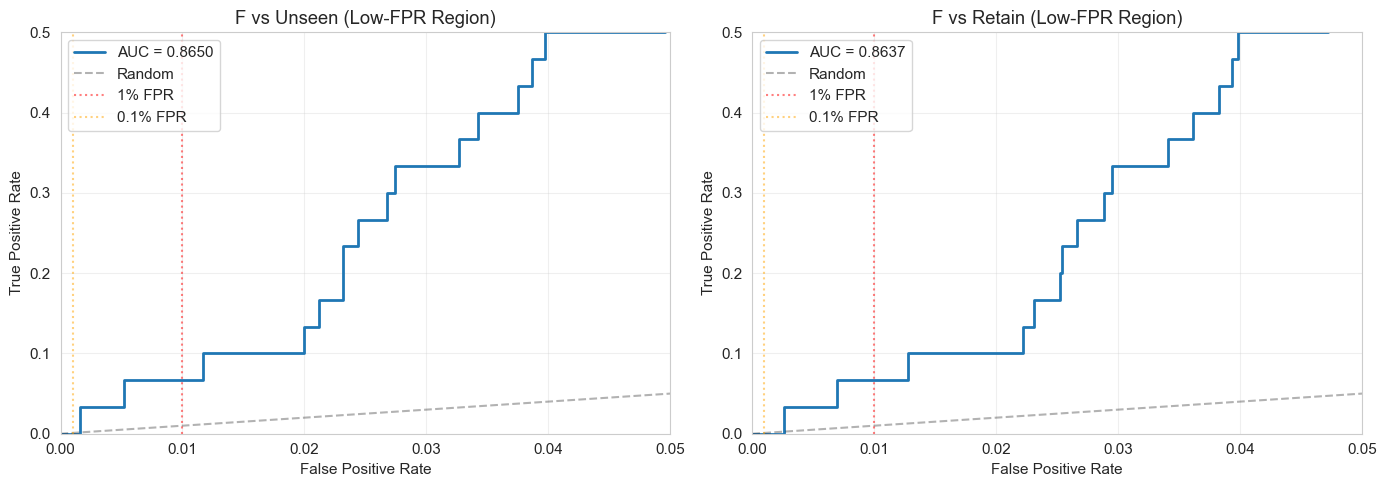

In [12]:
# Zoom into low-FPR region
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F vs Unseen (zoomed)
axes[0].plot(fpr_f_vs_u, tpr_curve_f_vs_u, linewidth=2, label=f'AUC = {auc_f_vs_u:.4f}')
axes[0].plot([0, 0.05], [0, 0.05], 'k--', alpha=0.3, label='Random')
axes[0].axvline(0.01, color='red', linestyle=':', alpha=0.5, label='1% FPR')
axes[0].axvline(0.001, color='orange', linestyle=':', alpha=0.5, label='0.1% FPR')
axes[0].set_xlim([0, 0.05])
axes[0].set_ylim([0, 0.5])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('F vs Unseen (Low-FPR Region)')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# F vs Retain (zoomed)
axes[1].plot(fpr_f_vs_r, tpr_curve_f_vs_r, linewidth=2, label=f'AUC = {auc_f_vs_r:.4f}')
axes[1].plot([0, 0.05], [0, 0.05], 'k--', alpha=0.3, label='Random')
axes[1].axvline(0.01, color='red', linestyle=':', alpha=0.5, label='1% FPR')
axes[1].axvline(0.001, color='orange', linestyle=':', alpha=0.5, label='0.1% FPR')
axes[1].set_xlim([0, 0.05])
axes[1].set_ylim([0, 0.5])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('F vs Retain (Low-FPR Region)')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/p2/retrain_floor_roc_zoomed.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Summary and Target Setting

In [ ]:
avg_auc_floor = (auc_f_vs_u + auc_f_vs_r) / 2

print("="*70)
print("RETRAIN FLOOR RESULTS")
print("="*70)
print("\nAUC (Two-Negative, Conditioned):")
print(f"  F vs Unseen: {auc_f_vs_u:.4f} (95% CI: [{ci_f_vs_u[0]:.4f}, {ci_f_vs_u[1]:.4f}])")
print(f"  F vs Retain: {auc_f_vs_r:.4f} (95% CI: [{ci_f_vs_r[0]:.4f}, {ci_f_vs_r[1]:.4f}])")
print(f"  Average:     {avg_auc_floor:.4f} ← AUC_floor")

print("\nTPR at Low FPR (F vs Unseen):")
print(f"  TPR @ 1.0% FPR: {tpr_f_vs_u['tpr@1.0%fpr']:.4f}")
print(f"  TPR @ 0.1% FPR: {tpr_f_vs_u['tpr@0.1%fpr']:.4f}")

print("\nTPR at Low FPR (F vs Retain):")
print(f"  TPR @ 1.0% FPR: {tpr_f_vs_r['tpr@1.0%fpr']:.4f}")
print(f"  TPR @ 0.1% FPR: {tpr_f_vs_r['tpr@0.1%fpr']:.4f}")

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)

if avg_auc_floor > 0.60:
    print(f"\nAUC_floor = {avg_auc_floor:.4f} >> 0.5")
    print("\nPrivacy leakage PERSISTS even after full retrain from scratch!")
    print("\nThis is expected because:")
    print("  - Forget set is small (35 cells)")
    print("  - Forget set is a rare cluster (inherently different from rest)")
    print("  - Even training without these cells, their 'absence' is detectable")
    print("\nREVISED TARGET:")
    lower_target = avg_auc_floor - 0.03
    upper_target = avg_auc_floor + 0.03
    print(f"  Unlearning should achieve: AUC ≈ {avg_auc_floor:.4f} ± 0.03")
    print(f"  Target band: [{lower_target:.4f}, {upper_target:.4f}]")
    print("\nThis is MUCH more realistic than the original AUC ~ 0.50 target.")
    print("The goal is 'retrain-equivalence', not 'perfect unlearning'.")
else:
    print(f"\nAUC_floor = {avg_auc_floor:.4f} ~ 0.5")
    print("\nFull retrain successfully removes privacy signal.")
    print("Unlearning target remains: AUC ~ 0.50 ± 0.03")

print("\n" + "="*70)

## 8. Save Results

In [ ]:
import os
os.makedirs('outputs/p2', exist_ok=True)

results = {
    'timestamp': str(np.datetime64('now')),
    'method_id': 'retrain_floor',
    'model': 'retrain_structured (gold-standard D\\F)',
    'forget_size': int(len(forget_idx)),
    'unseen_size': int(len(unseen_idx)),
    'retain_size': int(len(retain_idx)),
    'auc_f_vs_unseen': float(auc_f_vs_u),
    'auc_f_vs_retain': float(auc_f_vs_r),
    'auc_f_vs_unseen_ci': [float(ci_f_vs_u[0]), float(ci_f_vs_u[1])],
    'auc_f_vs_retain_ci': [float(ci_f_vs_r[0]), float(ci_f_vs_r[1])],
    'tpr_at_fpr_f_vs_unseen': {k: float(v) for k, v in tpr_f_vs_u.items()},
    'tpr_at_fpr_f_vs_retain': {k: float(v) for k, v in tpr_f_vs_r.items()},
    'avg_auc_floor': float(avg_auc_floor),
    'target_band': [float(avg_auc_floor - 0.03), float(avg_auc_floor + 0.03)],
    'interpretation': 'AUC_floor >> 0.5' if avg_auc_floor > 0.60 else 'AUC_floor ~ 0.5'
}

with open('outputs/p2/retrain_floor.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to: outputs/p2/retrain_floor.json")
print("Figures saved to: outputs/p2/retrain_floor_roc*.png")

## 9. Comparison with Previous Results

In [ ]:
print("="*70)
print("COMPARISON: Retrain Floor vs Best Unlearning So Far")
print("="*70)

comparison = [
    ('Baseline (no unlearning)', 0.9509, 0.9488),
    ('Lambda=0.5 (best so far)', 0.9057, 0.9033),
    ('Lambda=10 (v3)', 0.9368, 0.9352),
    ('Lambda=100 (v3, failed)', 0.9548, 0.9530),
    ('', None, None),  # Separator
    ('RETRAIN FLOOR (goal)', auc_f_vs_u, auc_f_vs_r),
]

print("\n{:30s} | {:12s} | {:12s}".format('Model', 'F vs Unseen', 'F vs Retain'))
print("-" * 70)
for name, auc_u, auc_r in comparison:
    if auc_u is None:
        print("")
    else:
        print("{:30s} | {:12.4f} | {:12.4f}".format(name, auc_u, auc_r))

print("\n" + "="*70)
print("CONCLUSION")
print("="*70)
print(f"\nBest unlearning (Lambda=0.5): AUC ~ 0.906")
print(f"Retrain floor:                AUC ~ {avg_auc_floor:.3f}")
print(f"Gap to retrain:               ΔAUC ~ {0.9057 - avg_auc_floor:+.3f}")

if avg_auc_floor > 0.60:
    if 0.9057 <= avg_auc_floor + 0.03:
        print("\nLambda=0.5 is WITHIN TARGET BAND!")
        print("Frozen single-critic already achieved retrain-equivalence.")
    else:
        print("\nLambda=0.5 is ABOVE target band.")
        print("Multi-critic may improve further toward retrain floor.")

print("\nNext step: Implement multi-critic training.")